We begin by importing all the necessary packages. In this case, we use giotto-tda `gtda` in python to perform our homology computations. The goal of this project is to take point clouds pertaining to various shapes, extract their topological features using giotto, and then train a classifier on the topological data rather than on the point clouds directly. The hope is that, with clean (vectorized) homologies, we could achieve similar classification performance, but we would have reduced our input feature size to about a tenth of what we would have needed if we trained a classifier on the point clouds directly.

In [1]:
import gtda 
import numpy as np
from generate_data import *
from gtda.plotting import plot_point_cloud
from gtda.homology import VietorisRipsPersistence
from gtda.homology import WeakAlphaPersistence
from gtda.diagrams import PersistenceEntropy
import matplotlib.pyplot as plt
from gtda.plotting import plot_diagram
from sklearn.ensemble import RandomForestClassifier
from openml.datasets.functions import get_dataset
from gtda.diagrams import Amplitude, NumberOfPoints
from sklearn.pipeline import make_union
from gtda.pipeline import Pipeline 
import pandas as pd
import matplotlib.pyplot as plt

Helper function to make some point clouds X:


In [2]:
def make_point_clouds(n_samples_per_shape: int, n_points: int, noise: float):
    #--- circles ---
    circle_point_clouds = [
        np.asarray(
            [
                [np.sin(t) + noise * (np.random.rand(1)[0] - 0.5), np.cos(t) + noise * (np.random.rand(1)[0] - 0.5), 0]
                for t in range((n_points ** 2))
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    circle_labels = np.zeros(n_samples_per_shape)  # label circles with 0

    #--- spheres ---
    sphere_point_clouds = [
        np.asarray(
            [
                [
                    np.cos(s) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.cos(s) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]
    sphere_labels = np.ones(n_samples_per_shape)     # label spheres with 1

    #--- tori ---
    torus_point_clouds = [
        np.asarray(
            [
                [
                    (2 + np.cos(s)) * np.cos(t) + noise * (np.random.rand(1)[0] - 0.5),
                    (2 + np.cos(s)) * np.sin(t) + noise * (np.random.rand(1)[0] - 0.5),
                    np.sin(s) + noise * (np.random.rand(1)[0] - 0.5),
                ]
                for t in range(n_points)
                for s in range(n_points)
            ]
        )
        for kk in range(n_samples_per_shape)
    ]

    torus_labels = 2 * np.ones(n_samples_per_shape)     # label tori with 2

    #--- plane ---
    coefs = list(zip((1+6*np.random.rand(n_samples_per_shape)).astype(int), (1+6*np.random.rand(n_samples_per_shape)).astype(int)))
    plane_point_clouds = [
        np.asarray(
            [
                [
                    x,
                    y,
                    coef[0]*x + coef[1]*y,
                ]
                for x in np.linspace(-1, 1, n_points)
                for y in np.linspace(-1, 1, n_points)
            ]
        )
        for coef in coefs
    ]
    plane_labels = 3 * np.ones(n_samples_per_shape) # label plane with 3

    point_clouds = np.concatenate((circle_point_clouds, sphere_point_clouds, torus_point_clouds, plane_point_clouds))
    labels = np.concatenate((circle_labels, sphere_labels, torus_labels, plane_labels))

    return point_clouds, labels

Below we generate point clouds (and ensure that the data has the expected shape.

In [3]:
n_samples_per_class = 10
point_clouds, labs = make_point_clouds(n_samples_per_class, n_points = 10, noise=0.1)
print(point_clouds.shape)
print(labs.shape)

(40, 100, 3)
(40,)


Here are some of the point clouds (circle, sphere, torus and a plane) visualized! 

In [4]:
plot_point_cloud(point_clouds[0]).show()

In [5]:
plot_point_cloud(point_clouds[11]).show()

In [6]:
plot_point_cloud(point_clouds[20]).show()

In [7]:
plot_point_cloud(point_clouds[-1]).show()

Below we setup the simplex routine to generate a simplicial complex from each point cloud. In this case, we generate the VietorisRips complex from each point cloud. Finally, use the `fit_transform` function to generate the Rips complex and the persistence diagram for each of our point clouds in dimensions 0, 1 and 2. 

In [8]:
# Track connected components, loops, and voids
homology_dimensions = [0, 1, 2]

# Collapse edges to speed up H2 persistence calculation!
persistence = VietorisRipsPersistence(
    metric = "euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=False
)

diagrams = persistence.fit_transform(point_clouds)

Here are some of the persistence diagrams. Note: The off-diagonal points denote the persistence of a homology in the corresponding dimension. The further away from the diagonal a point is denotes how strong the persistence is. A strong dimension 0 persistence indicates the presence of connected components, a strong dimension 1 persistence indicates the presence of loops in our data and finally a strong dimension 2 persistence indicates the presence of voids in our data. Reality check: For the circle, we need to see strong dimension 0 and dimension 1 persistence, while for the sphere we need to see strong dimension 0 and dimension 2 persistence. 

In [9]:
plot_diagram(diagrams[0]).show() # Circle

In [10]:
plot_diagram(diagrams[11]).show()  # Sphere

In [11]:
plot_diagram(diagrams[20]).show() # Torus

In [12]:
plot_diagram(diagrams[-3]).show() # Plane

At this point, we compute the entropy of each diagram above, which produces an entropy value for each dimension - quantifying the average persistence of topological features of that dimension (in comparison to the trivial diagram with no off-diagonal points). In our case, since our homologies only go up to dimension 2, the entropies are vectors in R^3 which can be easily visualized! 

In [13]:
persistence_entropy = PersistenceEntropy()

# calculate topological feature matrix
X = persistence_entropy.fit_transform(diagrams)
plot_point_cloud(X).show()

And we see formation of clusters!!! So the entropy is a great way that (linearly) separates the shapes! So we can just train a classifier on the entropy values. Note that the input to our classifier now is just a 3 dimensional vector as opposed to a 300 dimensional vector had we fed in the entire point cloud with 100 points each with 3 numbers quantifying the x,y and z position values! This is a reduction of the input feature size by **two orders of magnitude**!!!

In [14]:
rf = RandomForestClassifier(oob_score=True)
rf.fit(X, labs)
print(f"OOB score: {rf.oob_score:.3f}")

OOB score: 1.000


We can see that our model performs exceptionally well with synthetically generated data. We will now implement a version for data from real 3-d models. We will use the data from Princeton's computer vision course for our implementation. This dataset is freely available via the get_dataset function in the openml library. The data file contains 40 different point clouds across 4 classes (i.e, 10 clouds per class), each with 400 points.

In [15]:
# Obtain the shapes dataset
df = get_dataset('shapes').get_data(dataset_format='dataframe')[0]
df.head()

C:\Users\ab251\AppData\Local\Temp\ipykernel_32560\1591671407.py:2: FutureWarning:

Starting from Version 0.15 `download_data`, `download_qualities`, and `download_features_meta_data` will all be ``False`` instead of ``True`` by default to enable lazy loading. To disable this message until version 0.15 explicitly set `download_data`, `download_qualities`, and `download_features_meta_data` to a bool while calling `get_dataset`.



,x,y,z,target
0,0.341007,0.318606,0.096725,human_arms_out9
1,0.329226,0.421601,0.056749,human_arms_out9
2,0.446869,0.648674,0.124090,human_arms_out9
3,0.314729,0.217860,0.070847,human_arms_out9
4,0.426678,0.919195,0.047609,human_arms_out9


In [16]:
plot_point_cloud(df.query('target == "human_arms_out3"')[["x", "y", "z"]].values)

Ensuring our data is read as desired.

In [17]:
point_clouds = np.asarray(
    [
        df.query("target == @shape")[["x", "y", "z"]].values
        for shape in df["target"].unique()
    ]
)
point_clouds.shape

(40, 400, 3)

In [18]:
# Initializing the Rips persistence routine again and generating persistence diagrams
persistence = VietorisRipsPersistence(
    metric="euclidean",
    homology_dimensions=homology_dimensions,
    n_jobs=6,
    collapse_edges=True,
)
persistence_diagrams = persistence.fit_transform(point_clouds)


We compute the entropy again and plot our entropy values -- and we don't observe nice clusters. This is expected out of real world data that doesn't have just a single prominent topological feature. So we should expect our model to not perform very well....  

In [19]:
persistence_entropy = PersistenceEntropy(normalize=True)
X = persistence_entropy.fit_transform(persistence_diagrams)
plot_point_cloud(X)

In [20]:
labs = np.zeros(40)
labs[10:20] = 1
labs[20:30] = 2
labs[30:] = 3

rf = RandomForestClassifier(oob_score=True, random_state=400)
rf.fit(X, labs)
rf.oob_score_

0.6

Not bad at all (note that random guessing would give an oob_score of 0.25)! But we can do better. For instance by only using the PersistenceEntropy to classify our shapes, we are averaging out the distribution of points on the persistence diagram which might hold important information - for instance, the number of off-diagonal points in our persistence diagrams could be a great predictor of how clean our homology is, which is bound to change between different classes (and thus might be a good predictor). In addition to persistence entropy, we can also have other measures of "amplitudes" that detect how far away a given persistence diagram is from the trivial persistence diagram (of the empty-set, where no homological information is observed in any dimension). Giotto comes built in with various standard amplitudes that are considered industry standard. Each of these amplitude will contribute to three new features (one for each homology dimension) that could potentially improve our classifier. 

In [21]:
metrics = [
    {"metric": metric}
    for metric in ["heat", "betti", "bottleneck", "wasserstein", "landscape"]
]


feature_union = make_union(
    PersistenceEntropy(normalize=True),
    NumberOfPoints(),
    *[Amplitude(**metric) for metric in metrics]
)

In [22]:
p = Pipeline(
    [
        ("features", feature_union),
        ("rf", RandomForestClassifier(oob_score=True, random_state=42)),
    ]
)
p.fit(persistence_diagrams, labs)
p["rf"].oob_score_


0.825

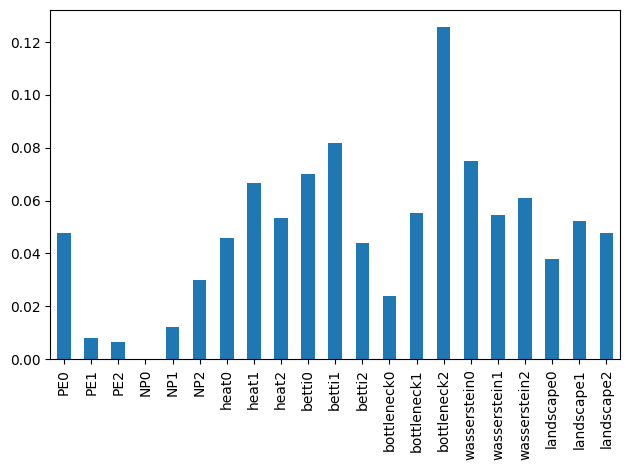

In [23]:
feature_types = ["PE", "NP", "heat", "betti", "bottleneck", "wasserstein", "landscape"]
feature_names = [type + str(i) for type in feature_types for i in homology_dimensions]
importances = p["rf"].feature_importances_
forest_importances = pd.Series(importances, index=feature_names)
fig, ax = plt.subplots()
forest_importances.plot.bar(ax=ax)
fig.tight_layout()


From here it looks like the most prominent predictors turn out to be 

1. Bottleneck distance in dimension 2, 
2. The betti amplitude in dimension 1, and
3. The Wasserstein metric in dimension 0

where the wasserstein metric behaves comparably to the betti amplitude in dimension 0 and the heat (homology contour) map in dimension 0.
